In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from ipywidgets import FloatProgress
from IPython.display import display

# Setup

In [3]:
PATH = Path('../data/pascal')
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [4]:
trn_json = json.load((PATH/'pascal_train2007.json').open())
cats = {o['id']:o['name'] for o in trn_json['categories']}
imgs_fn = {o['id']:o['file_name'] for o in trn_json['images']}
imgs_id = [o['id'] for o in trn_json['images']]

In [5]:
trn_anno = collections.defaultdict(lambda:[])
for annot in trn_json['annotations']:
    if annot['ignore'] == 0:
        bb = annot['bbox']
        #Transforms bb which is left,top, width, height into top, left, bottom, right.
        bb = [bb[1],bb[0],bb[1] + bb[3], bb[0]+bb[2]]
        trn_anno[annot[('image_id')]].append((bb, annot['category_id']))
len(trn_anno)

2501

In [6]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
size=224
batch_size=32

In [7]:
annot_cats = [[cats[int(ann[1])] for ann in trn_anno[i]] for i in imgs_id]
id2cats = list(cats.values())
cats2id = {c:i for i,c in enumerate(id2cats)}
model_cats = np.array([np.array([cats2id[c] for c in ac]) for ac in annot_cats])
model_cats

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [8]:
val_idx = get_cv_idxs(len(imgs_id))
((val_cats, trn_cats),) = split_by_idx(val_idx, model_cats)

Bboxes

In [9]:
model_bbs = [np.concatenate([ann[0] for ann in trn_anno[i]]) for i in imgs_id]
model_bbsc = [' '.join([str(p) for p in o]) for o in model_bbs]

In [10]:
df = pd.DataFrame({'fn': [imgs_fn[i] for i in imgs_id], 'bbs': model_bbsc},columns=['fn','bbs'])

In [11]:
df.to_csv(MBB_CSV, index=False)

In [12]:
aug_tfms = [RandomRotate(10, tfm_y = TfmType.COORD),
           RandomLighting(0.05,0.05, tfm_y = TfmType.COORD),
           RandomFlip(tfm_y = TfmType.COORD)]
tfms = tfms_from_model(f_model, size, aug_tfms=aug_tfms, crop_type=CropType.NO, tfm_y = TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4, val_idxs=val_idx, bs=batch_size)

In [13]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [14]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_cats)
val_ds2 = ConcatLblDataset(md.val_ds, val_cats)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

# Model and anchors

In [15]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2,ctr+hw/2], dim=1)

In [16]:
anc_grids = [4,2,1]
# anc_grids = [4]
anc_zooms = [0.75, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

Activations necessary for detecting one object

In [17]:
class StdConv(nn.Module):
    def __init__(self, n_in,n_out,stride=2,dp = 0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in,n_out,3,stride=stride,padding=1)
        self.bn = nn.BatchNorm2d(n_out)
        self.dropout = nn.Dropout(dp)
        
    def forward(self,x):
        return self.dropout(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k) 

In [18]:
class OutConv(nn.Module):
    def __init__(self, k, n_in, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(n_in, (len(id2cats)+1) * k, 3, padding=1)
        self.oconv2 = nn.Conv2d(n_in, 4 * k, 3, padding = 1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self,x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [19]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512,256, dp=drop)
        self.sconv2 = StdConv(256,256, dp=drop)
        self.sconv3 = StdConv(256,256, dp=drop)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

Writing the loss function

In [20]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, preds, targets):
        t = one_hot_embedding(targets, self.num_classes+1)
        t = V(t[:,:-1].contiguous()) #bg class is predicted when none of the others go out.
        x = preds[:,:-1]
        w = self.get_weight(x,t)# for the last part
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes
    
    def get_weight(self,x,t):
        return None

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cats))

In [21]:
def intersection(box_a,box_b):
    min_xy = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    max_xy = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp(max_xy-min_xy,min=0)
    return inter[:,:,0] * inter[:,:,1]

def get_size(box):
    return (box[:,2]-box[:,0]) * (box[:,3] - box[:,1])

def jaccard(box_a,box_b):
    inter = intersection(box_a,box_b)
    union = get_size(box_a).unsqueeze(1) + get_size(box_b).unsqueeze(0) - inter
    return inter/union

In [22]:
#Removes the zero padding in the target bbox/class
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/size
    bb_keep = ((bbox[:,2] - bbox[:,0])>0.).nonzero()[:,0]
    return bbox[bb_keep], clas[bb_keep]
    
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_ctrs = (actn_bbs[:,:2] * grid_sizes/2) + anchors[:,:2]
    actn_hw = (1 + actn_bbs[:,2:]/2) * anchors[:,2:]
    return hw2corners(actn_ctrs,actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False, use_ab=True):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, (anchor_cnr if use_ab else a_ic).data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cats)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

def ssd_loss2(pred,targ):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,use_ab=False)
        lls += loc_loss
        lcs += clas_loss
    return lls+lcs

In [23]:
head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

# NMS

In [24]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

# Plots

In [25]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [26]:
def bb_to_hw(bb):
    return [bb[1],bb[0],bb[3]-bb[1], bb[2]-bb[0]]

def show_img(im, figsize=None, axis=None):
    if not axis:
        fig,axis = plt.subplots(figsize=figsize)
    axis.imshow(im)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    return axis

def draw_outline(obj,lw):
    obj.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(axis, box, color='white'):
    patch = axis.add_patch(patches.Rectangle(box[:2],box[-2],box[-1],fill=False,edgecolor=color,lw=2))
    draw_outline(patch,4)
    
def draw_text(axis,xy,text,text_size=14, color='white'):
    patch = axis.text(*xy, text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
    draw_outline(patch,1)
    
def show_img_all(id_img):
    img = open_image(IMG_PATH/imgs_fn[id_img])
    axis = show_img(img, figsize=(16,8))
    for bbox, id_cat in trn_anno[id_img]:
        new_box = bb_to_hw(bbox)
        draw_rect(axis, new_box)
        draw_text(axis, new_box[:2], cats[id_cat])
        
def show_ground_truth(ax, im, bbox, clas = None, prs = None, tresh = 0.3):
    bb = [bb_to_hw(o) for o in bbox.reshape(-1,4)]
    if clas is None: clas = [None] * len(bb)
    if prs is None: prs = [None] * len(bb)
    ax = show_img(im,axis=ax)
    for i, (b,c,pr) in enumerate(zip(bb,clas,prs)):
        if b[2] > 0 and (pr is None or pr > tresh):#Show the bow only if there is something to show
            draw_rect(ax, b, colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c == len(id2cats) else id2cats[c])
            if pr is not None: txt += f'{pr:.2f}'
            draw_text(ax,b[:2],txt,color=colr_list[i%num_colr])
        
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

# False positives and negatives

We'll try to illustrate what are true positives (TP), false positives (FP) and false negatives (FN).

Place the file focus-4b.h5 in a folder named models inside the one where path is pointing to be able to load it.

In [27]:
learn.load('focus-4b')
learn.model.eval()
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
pred = learn.model(x)

Get the predictions after the NMS at a certain level of threshold.

In [28]:
def get1preds(b_clas,b_bb,bbox,clas,thresh=0.25):
    bbox,clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    clas_pr, clas_ids = b_clas.max(1)
    conf_scores = b_clas.sigmoid().t().data
    out1,out2,cc = [],[],[]
    for cl in range(conf_scores.size(0)-1):
        cl_mask = conf_scores[cl] > thresh
        if cl_mask.sum() == 0: continue
        scores = conf_scores[cl][cl_mask]
        l_mask = cl_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc)) if cc != [] else None
    out1 = torch.cat(out1) if out1 != [] else None
    out2 = torch.cat(out2) if out2 != [] else None
    return out1,out2,cc

In [29]:
def show_results(idx, thresh=0.25, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(6,6))
    ima=md.val_ds.ds.denorm(x)[idx]
    out1,out2,cc = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],thresh)
    torch_gt(ax, ima, out2, cc, out1, 0.1)
    
def show_gt(idx, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(6,6))
    ima = md.val_ds.ds.denorm(x)[idx]
    show_ground_truth(ax,ima,to_np(y[0][idx]),to_np(y[1][idx]))
    
def compare(idx,thresh=0.25):
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    show_results(idx,thresh,ax=axs[0])
    show_gt(idx,ax=axs[1])
    plt.tight_layout()

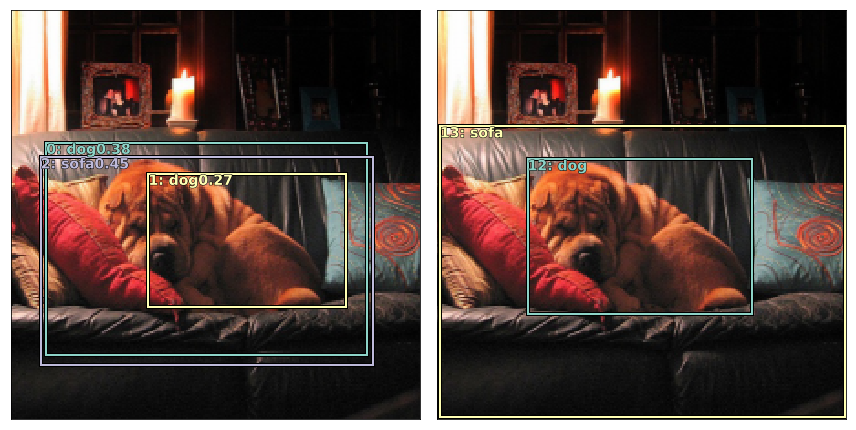

In [30]:
compare(1)

We can see the predicted objets on the right and the ground truth on the left.

To calculate the Precision (and Recall) for a given level of confidence (here 0.25), we first need to calculate the overlaps between our predictions and the ground truth. A prediction is considered to be a hit to a ground truth object if it overlaps it with more than 0.5. Then we will be able to determine the number of Tp, FP and FN.

Let's see this on that example.

In [31]:
def show_hits(idx,gt_obj,tresh=0.25):
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    ima=md.val_ds.ds.denorm(x)[idx]
    show_img(ima,axis=axs[1])
    boxes = to_np(y[0][idx].view(-1,4))
    idx_obj = boxes.shape[0] - 1 - gt_obj
    box = bb_to_hw(boxes[idx_obj])
    draw_rect(axs[1],box)
    draw_text(axs[1],box[0:2],id2cats[to_np(y[1][idx])[idx_obj]])
    out1,out2,cc = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],tresh)
    overlaps = jaccard(out2,y[0][idx].view(-1,4)[idx_obj].unsqueeze(0).data/224)
    hits = overlaps > 0.5
    bb_mask = hits.expand_as(out2)
    torch_gt(axs[0], ima, out2[bb_mask].view(-1,4), cc[hits], out1[hits], tresh)
    plt.tight_layout()

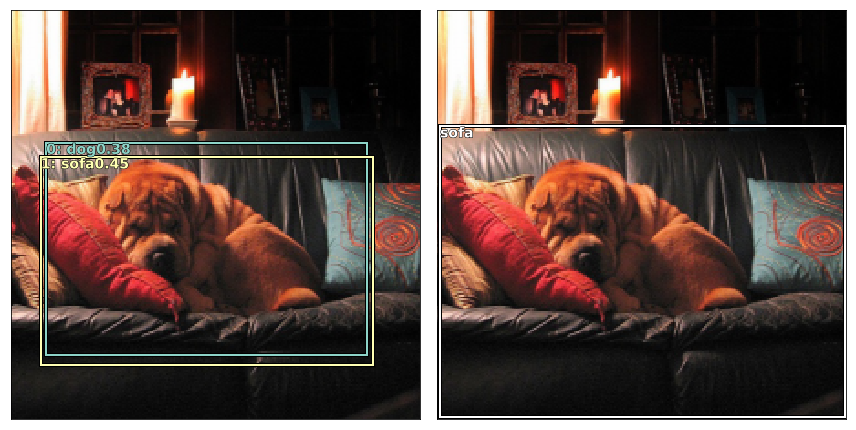

In [32]:
show_hits(1,0,0.25)

Here we have a predicted dog and predicted sofa that hit the sofa ground truth object.

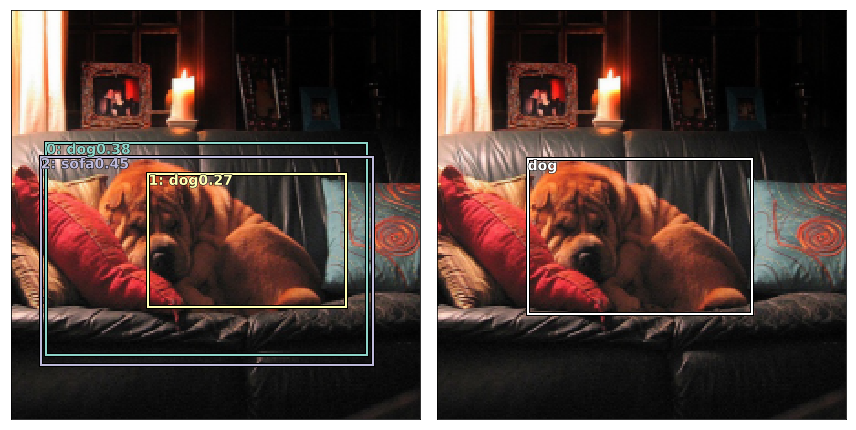

In [33]:
show_hits(1,1)

Here we have all our predicted objects hitting the dog ground truth object.

The question is: how do we decide with predicted box goes with which ground truth object? Quite logically, we will match it to the one that has the maximum overlap.

In [34]:
def show_match(idx,tresh=0.25):
    bbox,clas = get_y(y[0][idx],y[1][idx])#unpad the target
    p_scrs,p_box,p_cls = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],tresh)
    overlaps = jaccard(p_box,bbox.data)
    mx_overlap, mx_idx = overlaps.max(dim=1)
    hits = mx_overlap > 0.5
    #We draw one image per grounf truthobject, plus one image that will show the predictions hitting 
    #no ground truth object (if applicable)
    fig_sz = clas.size(0) if hits.sum() == p_scrs.size(0) else clas.size(0)+1 
    fig, axs = plt.subplots(fig_sz,2,figsize=(6,3 * fig_sz))
    ima=md.val_ds.ds.denorm(x)[idx]
    for i in range(0,clas.size(0)):#On the right we show the ground truth object
        ax = axs[i,1] if fig_sz > 1 else axs[1]#In case we have only one dimension
        show_img(ima,axis=ax)
        box = bb_to_hw(bbox[i].data * 224)
        draw_rect(ax,box)
        draw_text(ax,box[0:2],id2cats[clas.data[i]])
    for i in range(0,clas.size(0)):#On the left the predictions associated to it.
        msk = hits * (mx_idx==i)
        bmsk = msk.unsqueeze(1).expand_as(p_box)
        ax = axs[i,0] if fig_sz > 1 else axs[0]#In case we have only one dimension
        torch_gt(ax, ima, p_box[bmsk], p_cls[msk], p_scrs[msk], tresh)
    #If there are predictions hitting no ground truth object.
    if fig_sz==clas.size(0)+1:
        show_img(ima,axis=axs[clas.size(0),1])
        no_hit = mx_overlap <= 0.5
        bno_hit = no_hit.unsqueeze(1).expand_as(p_box)
        torch_gt(axs[clas.size(0),0], ima, p_box[bno_hit], p_cls[no_hit], p_scrs[no_hit], tresh)
    plt.tight_layout()

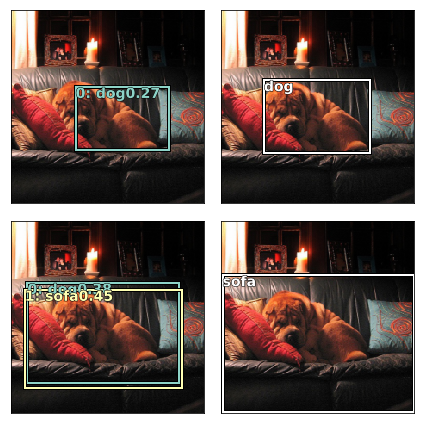

In [35]:
show_match(1)

With this kind of picture, it becomes easier to see the definitions of TP, FP and FN. Specifically, we say:

- a true positive TP is a prediction correctly matched to a ground truth object (applicable only once if we predict the same ground truth object multiple times, see below)
- a false negative FN is a ground truth object having no prediction (or #ground truth objects - #TP)
- a false positive is either:
  - a wrong prediction for a ground truth object
  - a right prediction for a ground truth object that has already been correctly identified
  - a prediction that doesn't hit any ground truth object.
  
Which can be summarized by: #FP = #predictions - #TP

For this picture we have:

- for the class dog: 1TP (first row) and 1FP (second row: a dog is predicted instead of a sofa)
- for the class sofa: 1TP

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


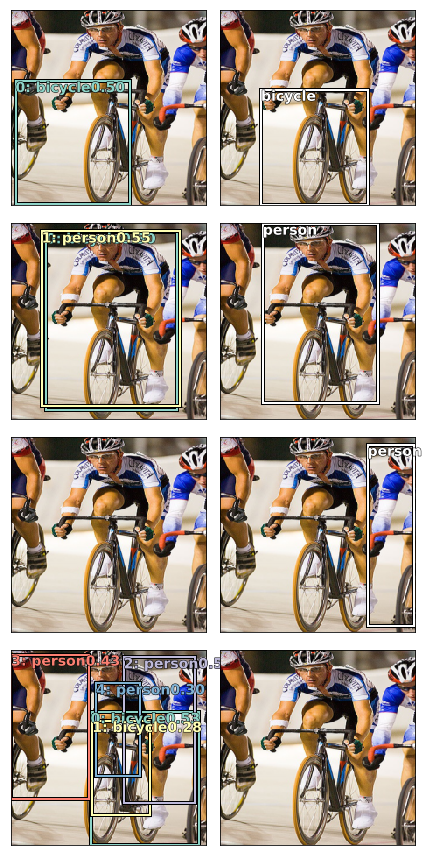

In [36]:
show_match(0)

Here we have:
- for the class bicycle: 1TP (first row), 1FP (second row) + 2FP (last row)
- for the class person: 1TP (second row), 1FN (third row) and 3FP (last row)

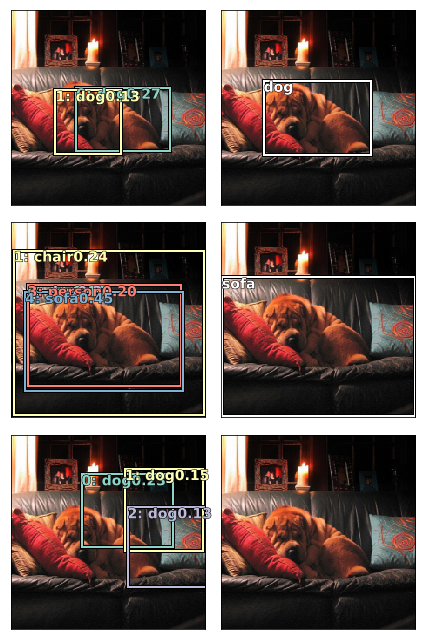

In [37]:
show_match(1,0.128)

Here the first line shows an example of FP of type 2: we have two predictions for the ground truth object dog, one counts as a TP, the other as a FP.

Let's see if we can get the TP, FP and FN for one set of predictions now. Let's take back the example of the picture of index 1

In [38]:
idx=0
out1,out2,cc = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],0.25)
bbox,clas = get_y(y[0][idx],y[1][idx])
overlaps = jaccard(out2,bbox.data)
mx_overlap, mx_idx = overlaps.max(dim=1)
mx_idx


 0
 0
 1
 0
 1
 2
 1
 1
[torch.cuda.LongTensor of size 8 (GPU 0)]

The mx_idx tensor allows us to match each prediction to a ground truth object (the one that it overlaps the most).

In [39]:
hits = mx_overlap > 0.5
hits


 0
 1
 1
 0
 1
 0
 0
 0
[torch.cuda.ByteTensor of size 8 (GPU 0)]

This tensor gives us all the predictions that are considered hitting a ground truth object (all the 0 are FP). If we want to check the predicted objects matching one particular ground truth object, we have to combine those two tensors.

In [40]:
msk = hits * (mx_idx==0)
cc[msk]


 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

Here we have one prediction for the ground truth object 0, which is of class 1.

In [41]:
msk = hits * (mx_idx==1)
cc[msk]


  1
 14
[torch.cuda.LongTensor of size 2 (GPU 0)]

And we have two p4rediction for the ground truth object 1, class 1 and 14. We can compare this to the ground truth which is present in the variable clas.

In [42]:
clas

Variable containing:
  1
 14
 14
[torch.cuda.LongTensor of size 3 (GPU 0)]

At this point, we can compute the number of truth positives for each class. Then: 
- FP = number of predictions - TP
- FN = number of ground truth objects - TP

Let's just create a function that counts the elements present in a list.

In [43]:
def count(L):
    result = collections.defaultdict(int)
    if L is not None:
        for x in L:
            result[x] += 1
    return result

In [44]:
count(cc)

defaultdict(int, {1: 4, 14: 4})

In [45]:
def get_TPFPFN_idx(idx,thresh):
    tp,fp,fn = np.zeros(len(id2cats)),np.zeros(len(id2cats)),np.zeros(len(id2cats))
    p_scr,p_box,p_cls = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],thresh)
    bbox,clas = get_y(y[0][idx],y[1][idx])
    new_tp = collections.defaultdict(int)
    if p_cls is not None:#If there are no predictions, we can skip to the second part.
        overlaps = jaccard(p_box,bbox.data)
        mx_overlap, mx_idx = overlaps.max(dim=1)
        hits = mx_overlap > 0.5
        #detect all the tp.
        for i in range(clas.size(0)):
            cl = clas.data[i]
            msk = hits * (mx_idx==i)
            if cl in p_cls[msk]:
                new_tp[cl] += 1
    count_pred = count(p_cls)
    count_gt = count(list(clas.data))
    for c in range(len(id2cats)):
        tp[c] += new_tp[c]
        fp[c] += count_pred[c] - new_tp[c]
        fn[c] += count_gt[c] - new_tp[c]
    return tp, fp, fn 

In [46]:
get_TPFPFN_idx(1,0.25)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

As we saw, there is one TP for the category dog, one TP for the category sofa and one FP for the cateogry dog.

In [47]:
get_TPFPFN_idx(0,0.25)

(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

This is also in line with what we we had seen, there is one TP and 3 FP for the category bicycle; one TP, 3 FP and one FN for the category person.

Now let's iterate over all the data.

In [48]:
def get_TPFPFN(thresh):
    tp,fp,fn = np.zeros(len(id2cats)),np.zeros(len(id2cats)),np.zeros(len(id2cats))
    for data in md.val_dl:
        x,y = data
        x,y = V(x),V(y)
        pred = learn.model(x)
        for idx in range(x.size(0)):
            p_scr,p_box,p_cls = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],thresh)
            bbox,clas = get_y(y[0][idx],y[1][idx])
            new_tp = collections.defaultdict(int)
            if p_cls is not None:#If there are no predictions, we can skip to the second part.
                overlaps = jaccard(p_box,bbox.data)
                mx_overlap, mx_idx = overlaps.max(dim=1)
                hits = mx_overlap > 0.5
                #detect all the tp.
                for i in range(clas.size(0)):
                    cl = clas.data[i]
                    msk = hits * (mx_idx==i)
                    if cl in p_cls[msk]:
                        new_tp[cl] += 1
            count_pred = count(p_cls)
            count_gt = count(list(clas.data))
            for c in range(len(id2cats)):
                tp[c] += new_tp[c]
                fp[c] += count_pred[c] - new_tp[c]
                fn[c] += count_gt[c] - new_tp[c]
    return tp, fp, fn    

In [49]:
tp,fp,fn = get_TPFPFN(0.25)

In [50]:
tp

array([ 19.,  11.,  26.,   2.,   5.,  13.,  48.,  22.,   8.,   5.,   6.,  22.,  22.,  17., 157.,   4.,   0.,
         7.,  14.,   6.])

In [51]:
fp

array([ 17.,  26.,  40.,  18.,  12.,   4.,  58.,   4.,  62.,   5.,   9.,  33.,  18.,   8., 341.,  16.,  27.,
        37.,  11.,  12.])

In [52]:
fn

array([ 16.,  25.,  37.,  34.,  58.,  16.,  84.,  12.,  46.,  28.,  14.,  29.,  10.,  20., 333.,  27.,  20.,
        14.,  14.,  23.])

We could iterate the last function over a range of thresholds but it's really slow, and we would everything (NMS, matiching predictions to ground truth objects...) a lot of times whereas increasing the threhold will just make predictions disappear. Hence, we jsut have to execute the previous function to get the prediction for the minimum threshold and we will apply various masks to hide the predictions that doesn't meat a higher one.

In [53]:
from ipywidgets import FloatProgress
from IPython.display import display
def multiTPFPFN():
    n = 40
    threshes = np.linspace(.05, 0.95, n, endpoint=True)
    tps,fps,fns = np.zeros((n,len(id2cats))),np.zeros((n,len(id2cats))),np.zeros((n,len(id2cats)))
    prog = FloatProgress(min=0,max=len(md.val_dl))
    display(prog)
    for data in md.val_dl:
        x,y = data
        x,y = V(x),V(y)
        pred = learn.model(x)
        for idx in range(x.size(0)):
            p_scr,p_box,p_cls = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],threshes[0])
            bbox,clas = get_y(y[0][idx],y[1][idx])
            overlaps = jaccard(p_box,bbox.data)
            mx_overlap, mx_idx = overlaps.max(dim=1)
            hits = mx_overlap > 0.5
            for k in range(threshes.shape[0]):
                #detect all the tp at threshold threshes[k]
                new_tp = collections.defaultdict(int)
                for i in range(clas.size(0)):
                    cl = clas.data[i]
                    msk = hits * (mx_idx==i) * (p_scr > threshes[k])
                    if cl in p_cls[msk]:
                        new_tp[cl] += 1
                count_pred = count(p_cls[p_scr > threshes[k]])
                count_gt = count(list(clas.data))
                for c in range(len(id2cats)):
                    tps[k,c] += new_tp[c]
                    fps[k,c] += count_pred[c] - new_tp[c]
                    fns[k,c] += count_gt[c] - new_tp[c]
        prog.value += 1
    return tps, fps, fns    

It still takes one minute or so to run, but it's faster this way.

In [ ]:
%time tps, fps, fns = multiTPFPFN()

FloatProgress(value=0.0, max=16.0)

We can plot the prec/recall curve for a given class. Precision = TP / (TP+FP), Recall = TP / (TP + FN)

In [190]:
def plot_prec_recall(clas):
    prec = np.where(tps[:,clas] + fps[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fps[:,clas]), 1)
    recal = np.where(tps[:,clas] + fns[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fns[:,clas]), 1)
    plt.plot(recal,prec)

C:\Users\Sylvain\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


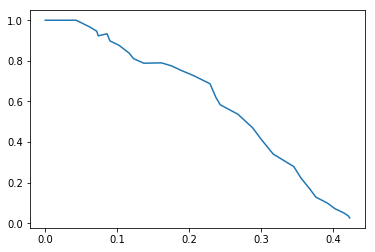

In [191]:
plot_prec_recall(14)

The idea is that we can a very precise model if we only make predictions when we are absolutely sure of them. But that means getting a lot of FN, so a very low recall (that's the beginning of the curve). As we adjust the threshold for our predictions, we get less and less FN, but we also get more and more FP, hence getting a lower and lower precision.

The AP (average precision) for a given class is the surface beneath the previous curve, or $\displaystyle\int_{0}^{1} \hbox{prec}(\hbox{rec}) \hbox{drec}$.

It's approximated by the mean of the precision at recalls at 0, 0.1, 0.2, ..., 1.

In [192]:
def avg_prec(clas):
    precisions = np.where(tps[:,clas] + fps[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fps[:,clas]), 1)
    recalls = np.where(tps[:,clas] + fns[:,clas] != 0, tps[:,clas]/(tps[:,clas] + fns[:,clas]), 1)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    return np.array(prec_at_rec).mean()

And finally we average the AP over all the classes.

In [193]:
def mAP():
    S = 0
    for i in range(len(id2cats)):
        S += avg_prec(i)
    return S/len(id2cats)

In [194]:
mAP()

C:\Users\Sylvain\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


0.30796475049736644